# Homework: KNN Classification for Employee Attrition

**Total: 120 points** • **Questions: 10**

This homework uses one dataset: **ibm_attrition** (CSV). You will practice:

- Working with a close-to-reality HRIS dataset addressing a recurrent HR problem: predicting employee attrition based on a rich features.
- Feature scaling
- Feature Selection
- Splitting data into train/test sets
- Developing understanding of where test split should and SHOULD NOT be used to prevent test signal leakage
- Fitting a KNN classifer for to predict employees that are at the most risk of leaving the company
- Evaluating the model performance against test split and finding optimal KNN parameters to maximize evaluation metrics

## Instructions (important)

- Do **not** hard-code answers; compute them from the data.
- Some questions ask you to create specific variables. **Name them exactly** as requested.
- If you're using Google Colab, you need to upload the downloaded dataset to your Colab Files section.
- For much of this homework, your solution will be self-guided. You may refer back to the lecture notebook for steps you need to follow and the order by which to follow those steps.
- Following guidance from the lecture will result in an **acceptable solution**. But for a **perfect solution**, further experimentation and exploration is needed.
- You may use additional tools and functions from `sklearn` but using any other libraries besides the ones provided in this notebook is **strictly prohibited**.

### Grading

This notebook uses autograding:

- The major part of the grade for this assignment comes from **Q7** but this question also depends on Q6 and others. Make sure you budget your effort proportionally.
- **Answer cells** are marked as `# YOUR CODE HERE` or `# YOUR ANSWER HERE` and will be graded.
- Remove `raise NotImplementedError()` once you start working on a solution.
- **Do not** edit the content of LOCKED cells.
- **Do not** attempt to DELETE or MOVE any of the included cells.
- You MAY ADD **additional code cells** to experiment. You may remove these added blocks once you're done with your work. But if you intend to show your work (graph, summaries etc.) or another cell depends on the content of the created cell, you may keep it.
- Besides the sanity check tests visible to you, we might use additional rigorous hidden tests that are only available after submission. Double-check your work for accuracy and do not rely on sanity checks.
- This notebook contains metadata for tracking. Do not share your notebook or create a new notebook from scratch.
- If anything breaks, save your work and download a fresh copy of the notebook from Canvas. You can copy your finished code and insert that block by block into the new copy.


In [2]:
# Setup

import hashlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

RANDOM_STATE = 2025

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


def dataframe_digest(df: pd.DataFrame) -> str:
    """
    Returns hexdigest of the hashed value of a given pands dataframe.
    """
    row_hashes = pd.util.hash_pandas_object(df, index=True)
    h = hashlib.sha256()
    h.update(row_hashes.values.tobytes())
    return h.hexdigest()

---
# Data Preprocessing

We are using the `ibm_attrition.csv` for this homework.

We first form and process our target vector `y` and feature matrix `X`.


In [3]:
df = pd.read_csv("ibm_attrition.csv")

# Dropping columns with no significant contribution.
df.drop(columns=["EmployeeCount", "EmployeeNumber", "StandardHours"], inplace=True)

print(f"Shape of df: {df.shape}")

df.head()

Shape of df: (1470, 32)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [4]:
assert (
    dataframe_digest(df)
    == "3e7e5b96a1eacc81f5b775506e69ef95cd3476d75bf6e0123dec51f823bc06db"
), (
    "Dataframe digest doesn't match. Either your data file is corruputed or you're using a differnt version of pandas library."
)

### Q1 (3 pts) – Manual Encoding

Use custom python dictionary to encode the target variable `"Attrition"`. No should be mapped to 0 and Yes should be mapped to 1. Assign the mapped object to a variable named `y`.

In [5]:
df["Attrition"].value_counts()

,count
Attrition,
No,1233
Yes,237


In [6]:
# y = ...
# YOUR CODE HERE

map = {"No": 0, "Yes": 1}
y = df["Attrition"].map(map)


In [7]:
assert isinstance(y, pd.core.series.Series), "y should be a pandas Series object"

### Q2 (2 pts) – Using LabelEncoder

Now perform the same encoding of label variable using `LabelEncoder()` from scikit-learn. Assign the resulting variable to `y2` The resulting variable from this question and previous question should be numerically equivalent but they may have different types.

In [8]:
target_encoder = LabelEncoder()
# y2 = ...
# YOUR CODE HERE

y2 = target_encoder.fit_transform(df["Attrition"])

#i imagine this serves as a sanity check?
df["Attrition"].value_counts()

,count
Attrition,
No,1233
Yes,237


In [9]:
assert isinstance(y2, np.ndarray), "y2 should be Numpy ndarray object"

In [10]:
assert np.isclose(sum(y), sum(y2), atol=0.0001), (
    "y and y2 should be numerically similar"
)

After we're done processing y vector, we can form our feature matrix `X`.

In [11]:
X = df.drop(columns="Attrition")

## Categorical vs. Numerical Features

Here we have to pursue different approaches for numerical and categorical columns. In the lecture we covered dealing with numerical features which we simply standardize. Here we remove the categorical features since numerical values provide good enough decision boundaries.

> **Advanced Topic:**  
> For categorical features we need to employ an encoding scheme (remember we also encoded our binary target y). But different encodoing schemes are used for features. One of the most popular schemes is one-hot-encoding and sklearn provides a `OneHotEncoder()` class for this purpose. This is an advanced topic that you may explore on your own but working with this encoder is somewhat similar to `StandardScaler()` class.  
> In the starter code below, we are simply dropping the categorical columns so we don't have to deal with them. If you decide to include them back in, you may do that in a future block of code. Remember that your notebook should execute from top to bottom, so make sure you're not accidentally overwriting your own code in lower blocks.  
> The object `X` will remain untouched which you can use to slice for categorical features.

In [12]:
# Here we separate out the categorical and numerical feature names.

numerical_feats = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
# You may use the categorical feature names stored in this object for
# indexing if you choose to include them back in.
categorical_feats = X.select_dtypes(include="object").columns.tolist()

print("categorical columns that will be dropped:")
print(categorical_feats)
# We continue working on X_num while leaving X on its own.
X_num = X.drop(columns=categorical_feats)
print("\n")
print(f"X_num shape: {df.shape}")

categorical columns that will be dropped:
['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


X_num shape: (1470, 32)


# Splitting and Scaling Sets

Pay attention to the order of operations here. We first split the data, then work on scaling both splits using parameters obtained **ONLY** from train split.  
Since KNN relies on distance metrics, it is very important to have features on the same scale. This is why we must choose a scaling scheme like standardization.  
The target `y` does not need scaling. Why?

> **Advanced Topic:**  
> If you choose to explore using categorical features, keep note of another complication.  
> You must split first, then scale the numerical features while encoding the categorical features.  
> Then you can concatenated them back into a unified feature matrix.

In [13]:
# Choice of random_state which we hardcoded in top of our notebook, can change your computations.
# We use this for code reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    X_num, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

## Q3 (4 pts) – Manual Feature Scaling

Scale the train and test splits of feature matrix X manually. Do not use `sklearn` provided methods here. Store the results in `X_train_scaled` and `X_test_scaled` objects respectively.

In [14]:
# X_train_scaled = ...
# X_test_scaled = ...

#calculating mean and std from training data
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

#applying standardization to both train and test
X_train_scaled = (X_train - train_mean) / train_std
X_test_scaled = (X_test - train_mean) / train_std

In [15]:
assert isinstance(X_train_scaled, pd.core.frame.DataFrame), (
    "X_train_scaled should be a pandas DataFrame"
)
assert isinstance(X_test_scaled, pd.core.frame.DataFrame), (
    "X_test_scaled should be a pandas DataFrame"
)


## Q4 (4 pts) – Examining Feature Scaling

In the code block below show if `X_train_scaled` and `X_test_scaled` are standardized.

In [16]:
#X_train_scaled is standardized (should both be true)
print("X_train_scaled:")
print(f"  Mean close to 0: {np.allclose(X_train_scaled.mean(axis=0), 0)}")
print(f"  Std close to 1: {np.allclose(X_train_scaled.std(axis=0), 1)}")
print()

#Check if X_test_scaled is standardized (should both be false)
print("X_test_scaled:")
print(f"  Mean close to 0: {np.allclose(X_test_scaled.mean(axis=0), 0)}")
print(f"  Std close to 1: {np.allclose(X_test_scaled.std(axis=0), 1)}")

X_train_scaled:
  Mean close to 0: True
  Std close to 1: True

X_test_scaled:
  Mean close to 0: False
  Std close to 1: False


Are these two feature sets standardized? Explain why.

YOUR ANSWER HERE

X_train_scaled is standardized (mean being close to/is 0 and std being close to/is 1) because we calculated the standardization parameters (mean and std) from the training data itself and applied them to it

X_test_scaled, on the other hand, is not standardized. We applied the same methods to scale it as we did train_mean and train_std, but the mean and std are not close to 0 and 1 respectively. This is because the test set has a different distribution compared to the training set. Also, the training set is meant to be what the model is trained on, it is expected that that set is better standardized than the test set, which is learning from the training set



## Q5 (2 pts) – Feature Scaling Using StandardScaler

Now let's scale both train and test X splits this time using provided method from sklearn.  
- Save the output to `X_train_scaled_s` and `X_test_scaled_s` object.  
- The results should be numerically equivalent to those you obtained manually in a previous question.

In [17]:
scaler = StandardScaler()
# X_train_scaled_s = ...
# X_test_scaled_s = ...

scaler = scaler.fit(X_train)

#fit on training data and transforming both
X_train_scaled_s = scaler.fit_transform(X_train)
X_test_scaled_s = scaler.transform(X_test)

> **Advanced Topic:**
> You can examine the scaler object to see the feature names.
> These are stored in the object after .fit() is called on StandardScaler instance and a dataset is passed to it.

In [18]:
assert isinstance(X_train_scaled_s, np.ndarray), (
    "X_train_scaled_s should be a numpy ndarray type"
)
assert isinstance(X_test_scaled_s, np.ndarray), (
    "X_test_scaled_s should be a numpy ndarray type"
)

In [19]:
scaler.get_feature_names_out()

array(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'], dtype=object)

---
# Feature Selection and Model Fitting

## Q6 (8 pts) – Feature Selection

Here you need to perform a few steps to filter and select the features that provide the best model.  
- What constitutes a good model is usually a combination of explainability as well as the performance of predictions.  
- While explaining the process is important, for the purpose of this assignment we aim to maximize the prediction performance of the model.  
- Feature selection is usually a cyclic and iterative approach. You first select some features based on what you see from the data or theories you have about their predictive power. Then you fit the model. Then you come back to drop or add other features. Rinse and repeat.  
- Model fitting will follow this step.

> You can explain your process in the provided block below.  
> You may also use additional code blocks for tables, summaries, graphs etc.  
> When done, you'd need to store your feature names in the provided `selected_features` list.

Explanations:

I am going to perform feature selection based on two things: the correlation with attrition and on multicolinearity. I want features that have high correlation with attrition, but I want to ensure that I avoid features that are correlated with each other.

Process:
- First, create a correlation matrix to see all of the features listed out similar to what was done in the lecture notebook to see the strong correlations (based on the notebook, there are many that are 0/near 0. So I will set a thershold on my features)
- Then, I would see which features show multicolinearity and not looking at those. I would keep the multicolinearity threshold higher (0.7 and above) so I have more data to work with and hopefully that could feed the model more
- Lastly, after this process of identifying and choosing variables, I should be able to test the model and work on optimizing the F1 score to make the model more accurate

Explanation Part 2:

So, the explanation I described above is what I wanted to do in an ideal world, and that was my original plan. However, when I went through and coded it all and ran it: I got an F1 score of 0. My accuracy was high, but getting that low score was very demoralizing.

Afterwards, and you will see this reflected in my code below, I went through many trial and errors trying to increase my score. I first started by adjusting the colinear pairs to be lower thresholds (0.3), then higher ones (0.7), then extremely high ones (0.9). None of these worked, so I scrapped that idea all together. I opted for no colinearity and removed nothing and added nothing, as this was getting me the best results.

Further, on Q7, it was a large mess there as well. I started by lowering the nearest neighbors from 25 to 11 to 5 to 9 and then I finally settled on 7. I got the suggestion to weigh it by distance and set the p=2 and that improved it a little but not as much as I wanted it to be at.

Afterwards, I started to adjust the threshold as that started to increase my f1 and accuracy more than any of the other suggestions did, after that it was about finding the perfect balance to get the most f1 and accuracy I could. My last changes was made to the target cor threshold which I lowered to 0.8 instead of 1, and that finally got me to an f1 and accuracy value that i was happy with. It is not perfect which bugs me, but I am happy with it.

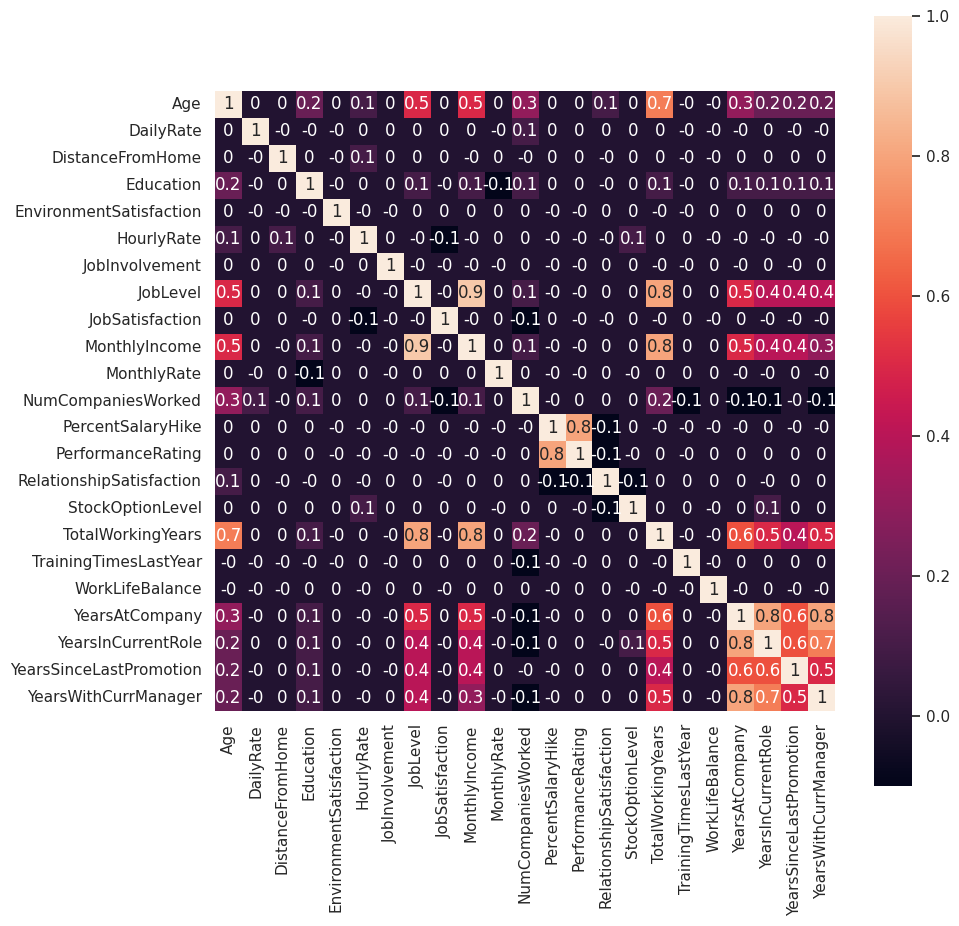

In [20]:
#creating correlation matrix from training data
train_df = pd.concat([X_train_scaled, y_train], axis=1)
corr = train_df.corr().round(2)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    train_df.drop(columns="Attrition").corr().round(1), annot=True, square=True, ax=ax
)

#filtering out and storing features with high correlation to target (y).
target_cor_threshold = 0.08
highly_corr = corr.loc[corr["Attrition"].abs() >= target_cor_threshold, "Attrition"]

#id the highly collinear feature pairs (threshold 0.9)
multicol_threshold = 0.9
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
pairs = corr.where(mask).stack().reset_index()
pairs.columns = ["feat1", "feat2", "corr"]
pairs = pairs[pairs["corr"].abs() >= multicol_threshold].sort_values(by="feat1")

#print("Highly collinear pairs (>= 0.9):")
#print(pairs)

#removing highly collinear features to avoid redundancy
#based on correlation >= 0.7:
#remove MonthlyIncome, TotalWorkingYears, YearsInCurrentRole, YearsWithCurrManager
#andPercentSalaryHike
#removal = ["MonthlyIncome"]

#some additional features that might help, taken from lecture book but
#probably not needed. I will take out if I have to or at least comment it
#extras = ["PerformanceRating", "RelationshipSatisfaction", "WorkLifeBalance"]

#combining features
selected_features = [f for f in highly_corr.index.to_list() if f != "Attrition"]
#retained_features = [f for f in highly_corr.index.to_list() if f not in removal
                     #and f != "Attrition"]
#retained_features.extend(extras)

In [21]:
# selected_features = [
#     "Age",
#     "DistanceFromHome",
#     "JobInvolvement",
# ]

#selected_features = retained_features
print(f"\nSelected features: {selected_features}")


Selected features: ['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'StockOptionLevel', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']


In [22]:
assert isinstance(selected_features, list), "selected_features must be a list"
assert len(selected_features) >= 3, "You should at least select 3 features"
assert all(isinstance(el, str) for el in selected_features), (
    "All elements of selected_features should be strings."
)


## Q7 (80 pts) – Model Fitting and Evaluation

Now it's time to train your model.  
- Besides k `n_neighbors`, our classifier has other hyper-parameters as well which you may choose to tweak.  
- Remember this is an iterative process. You pick some hyper-paramerts, fit the model, evaluate, tweak parameters, fit and evaluate.
- The other part of the iteration is feature selection. You may need to go back to that many times to fit a great model.

**Grading:**  
- You must optimize for your model's accuracy and F1 score (F1 for attrition class)  
- This question is worth 80/120 of your total score for this assignment
- 50/80 comes from F1 score for attrition class

| F1 Score     | Points |
| ------------ | ------ |
| >= 0.36      | 50     |
| 0.33 - 0.359 | 47     |
| 0.30 - 0.329 | 42     |
| 0.25 - 0.299 | 35     |
| 0.20 - 0.249 | 30     |
| 0.12 - 0.199 | 20     |
| 0.06 - 0.119 | 10     |
| < 0.06       | 0      |

- 30/80 comes from the overall accuracy

| Accuracy     | Points |
| ------------ | ------ |
| >= 0.85      | 30     |
| 0.83 - 0.849 | 22     |
| 0.81 - 0.829 | 15     |
| < 0.81       | 0      |


> **Note:**  
> We use your fitted model named `model` to grade your work.


In [23]:
# A base solution is provided here.
# Slicing our feature sets to only include our selected_features
X_train_retained = X_train_scaled[selected_features]
X_test_retained = X_test_scaled[selected_features]

# You can supply different parameters to metric, weights, and p arguments of the classifier
# to override the default values. Some of these might improve evaluation metrics
# Defining the model:
#i changed the number of neighbors for it to be smaller, added weights to distance
model = KNeighborsClassifier(n_neighbors=7, weights='distance', p=2)
# Fitting to train set
model.fit(X_train_retained, y_train)
# Making predictions
#y_pred = model.predict(X_test_retained)

# Get prediction probabilities
y_pred_proba = model.predict_proba(X_test_retained)

# Lower the threshold for predicting attrition (class 1)
# Default is 0.5, let's try 0.3 to catch more attrition cases
threshold = 0.42
y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

# Slicing our feature sets to only include our selected_features
X_train_retained = X_train_scaled[selected_features]
X_test_retained = X_test_scaled[selected_features]

# Calculating average accuracy and F1 score for attrition class.
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"F1 Score for Attrition Class: {f1:.3f}")
print(f"Overall Accuracy: {accuracy:.3f}")

# Most of the base solution is implemented for you.
# You can simply remove the error code and run.

#i wanted to add a confusion matrix and classification report for this analysis
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Positives (caught attrition): {cm[1,1]}")
print(f"False Negatives (missed attrition): {cm[1,0]}")
print(f"Recall (how many attrition cases we caught): {cm[1,1]/(cm[1,1]+cm[1,0]):.3f}")
print("\nClassification Report:")
print(classification_report(
    y_test, y_pred, target_names=['No Attrition', 'Attrition'],
    digits=3))

F1 Score for Attrition Class: 0.362
Overall Accuracy: 0.837

Confusion Matrix:
[[291  18]
 [ 42  17]]

True Positives (caught attrition): 17
False Negatives (missed attrition): 42
Recall (how many attrition cases we caught): 0.288

Classification Report:
              precision    recall  f1-score   support

No Attrition      0.874     0.942     0.907       309
   Attrition      0.486     0.288     0.362        59

    accuracy                          0.837       368
   macro avg      0.680     0.615     0.634       368
weighted avg      0.812     0.837     0.819       368



In [24]:
assert isinstance(model, KNeighborsClassifier), (
    "model must be a sklearn KNeighborsClassifier."
)
assert hasattr(model, "classes_"), "Model does not appear fitted (missing classes_)."
assert hasattr(model, "n_features_in_"), (
    "Model does not appear fitted (missing n_features_in_)."
)
assert X_train_retained.shape[1] == len(selected_features), (
    "Ensure you are using the right feature subset for model training."
)

> **DO NOT delete the following empty cells. They contain your grading mechanism!**

> Hints for getting to 100% score:
> - Look for clues of why F1 score is not performing well.
> - Pay attention to relationship between accuracy and F1 score. Is there a way to improve one without sacrificing the other?
> - Look for other resources and signals in dataset.

---
# Predictions and Visualizations

## Q8 (6 pts) – Instance Prediction

Imagine this scenario:  
Our model is trained and fully deployed to our production environment. HR team sends us a list of employees and asks us to determine whether they are likely to leave the company. The managers of these employees have determined that they might be on the verge of callig in quits!  
You look at the list and see `John`. John is your buddy and he has complained about the work many times to you and said he's looking for work elsewhere.  
Here is what HRIS API call returns for John. Use this data and make a prediction using your model.

Save your model output to an object named `john_class`

> **Hint:**  
> This is a dictionary object (similar to what most API calls can return). How can you pass this to `.predict()` method from your model instance?

In [25]:
john = {
    "Age": 30,
    "BusinessTravel": "Travel_Frequently",
    "DailyRate": 109,
    "Department": "Research & Development",
    "DistanceFromHome": 5,
    "Education": 3,
    "EducationField": "Medical",
    "EnvironmentSatisfaction": 2,
    "Gender": "Female",
    "HourlyRate": 60,
    "JobInvolvement": 3,
    "JobLevel": 1,
    "JobRole": "Laboratory Technician",
    "JobSatisfaction": 2,
    "MaritalStatus": "Single",
    "MonthlyIncome": 2422,
    "MonthlyRate": 25725,
    "NumCompaniesWorked": 0,
    "Over18": "Y",
    "OverTime": "No",
    "PercentSalaryHike": 17,
    "PerformanceRating": 3,
    "RelationshipSatisfaction": 1,
    "StockOptionLevel": 0,
    "TotalWorkingYears": 4,
    "TrainingTimesLastYear": 3,
    "WorkLifeBalance": 3,
    "YearsAtCompany": 3,
    "YearsInCurrentRole": 2,
    "YearsSinceLastPromotion": 1,
    "YearsWithCurrManager": 2,
}

In [26]:
# This is a suggestion, there are many ways to read in this datapoint.

# j_df = ... # First create a DataFrame from john
# j_num = ... # Then slice using numerical feature (we have this in the notebook)
# j_scaled = ... # Then scale using your previous scaler object
# j_scaled_df = ... # Then turn back into a DataFrame
# j_selected = ... # Filter by your selected features
# john_class = model.predict(...) # Finally make a prediction

# First create a DataFrame from john
j_df = pd.DataFrame([john])

# Then slice using numerical features
j_num = j_df[numerical_feats]

# Then scale using the same scaler parameters from training
j_scaled = (j_num - X_train.mean(axis=0)) / X_train.std(axis=0)

# Then turn back into a DataFrame with proper column names
j_scaled_df = pd.DataFrame(j_scaled, columns=j_num.columns)

# Filter by your selected features
j_selected = j_scaled_df[selected_features]

# Finally make a prediction
john_class = model.predict(j_selected)[0]

print(f"Prediction for John: {john_class}({'Attrition' if john_class == 1 else 'No Attrition'})")

Prediction for John: 0(No Attrition)


In [27]:
assert isinstance(john_class, (np.int64, np.int32, int, np.ndarray)), (
    "john_class should be either of the specified classes"
)


## Q9 (2 pts) – Instance Prediction Continued

Explain what the oputcome of your model's prediction for John means.
YOUR ANSWER HERE

The model's prediction for John indicates whether he is likely to leave the company or not. If the prediction is 1 (Attrition), the model predicts that John is at high risk of leaving the company based on his profile characteristics. Conversley, if the prediction is 0 (No Attrition), the model predicts that John will likely stay with the company. Given John's profile and the context (complaining about work and looking for work eslewhere), the model should predict attrition. However, my model does not predict that attrition and says he is more likely to stay. Despite that, in this case scenario, HR should still focus on retention efforts for employees like John.

P.S: I think my model may be busted haha

## Q10 (4 pts) – Visualize Decision Boundaries

Pick two of the most influential features in your feature set (the ones you included in your final model), and plot decision boundaries for a range of K values. This range should include your chosen K value for your model as well.

> **Notes:**
> - Picking the most influential or determining feature can be somewhat subjective, and you may need to refer to what you did for your feature selection.
> - You can copy the entire `plot_decision_boundary()` function definition from lecture notebook. And use it similar to how we used it in lecture notebook.
> - Remember, the best K for the particular pair of features you choose here is not necessarily the best K for your fully fitted model. Why?

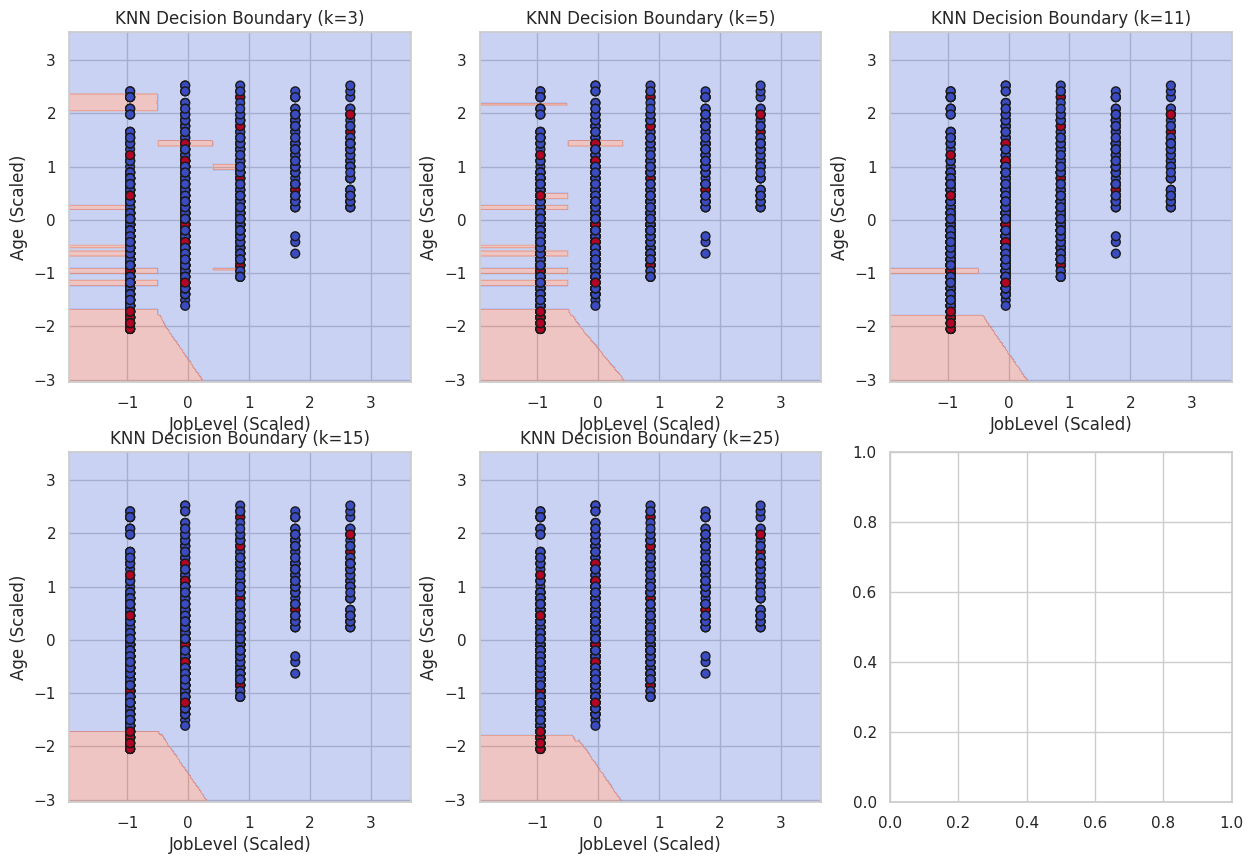

In [28]:
#copied the plot_decision_boundary function from lecture
def plot_decision_boundary(ax, X, y, k, feature_names, class_labels):
    """
    This function creates a mesh-grid filling up the entire data space
    Then predicts assigned labels for the entire mesh-grid
    The resulting predictions constitute the hypothetical decision boundary
    """
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300),
    )

    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    ax.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap="coolwarm",
        edgecolor="k",
        s=40,
    )

    ax.set_xlabel(f"{feature_names[0]} (Scaled)")
    ax.set_ylabel(f"{feature_names[1]} (Scaled)")
    ax.set_title(f"KNN Decision Boundary (k={k})")

#two most influential features
#JobLevel and Age have a consistent strong correlation with attrition, so
#they are chosen
feature1 = "JobLevel"
feature2 = "Age"

#data for these two features
X_train_2d = X_train_scaled[[feature1, feature2]].values
y_train_array = y_train.values

#plotting decision boundaries for different k values including our chosen k
k_values = [3, 5, 11, 15, 25]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, k in enumerate(k_values):
    plot_decision_boundary(
        axes[idx],
        X_train_2d,
        y_train_array,
        k,
        [feature1, feature2],
        ['No Attrition', 'Attrition']
    )

#this is to remove the extra subplot
fig.delaxes(axes[5])


plt.tight_layout()
plt.show()

## Q11 (5 pts) – Visualize Decision Boundaries Continued

Explain which K value makes the most sense for this particular feature pair. Can you explain what the decision boundaries mean at this K level? How they explain classification of observations?

YOUR ANSWER HERE

K=15 or K=25 makes the most sense for this feature pair. At K=3 and K=5, the boundaries are jagged and contain a lot of small red pockets scattered throughout the blue region, showing that is it overfitting. In K=15 and K=25, these bounaries look smoother and instead of the red regions being all over the place it is consoldiated into the corner, showing a better fitting model. The decision boundaries essentially show how influenced the prediction is by its neighbors, and how it classifies each prediction. If the K value is higher, then the predictions are more influenced by its neighbors compared to lower values. In this case, Joblevel seems to have more influence than Age, since the decision boundaries are more vertical than horizontal. Also, it shows that the lower JobLevel values have some red values (showing attrition) compared to the higher level ones.